### Group: Emma and Frankie
KNN Regression

In [40]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy as cp
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Import data and take a very quick look at it
# jmadata = pd.read_csv("./Data/jma_nitrate.csv")
jmadata = pd.read_csv("./data/jma_nitrate.csv")
jmadata.columns

Index(['Unnamed: 0', 'theta', 'sal', 'depth', 'nitrate', 'lon', 'lat', 'date',
       'year', 'month', 'day', 'profile', 'cruise', 'vessel', 'density'],
      dtype='object')

In [3]:
# Import Argo data without nitrate
# bgcdata = pd.read_csv('./Data/kuro_BGCargo_noNO3.csv')
infile = "./data/kuro_BGCargo_noNO3.csv"
bgcdata = pd.read_csv(infile, delimiter= ',')


bgcdata['year'] = pd.DatetimeIndex(bgcdata['Date/GMT']).year
bgcdata['month'] = pd.DatetimeIndex(bgcdata['Date/GMT']).month
bgcdata.columns





Index(['Date/GMT', 'Days since 1/1/1900', 'DEPTH[M]', 'PRESSURE[DBAR]', 'NA',
       'SALINITY[PSS]', 'TEMPERATURE[C]', 'SIGMATHETA[KG/M3]',
       'OXYGEN[uMOL/KG]', 'OXYGENSAT', 'LON', 'LAT', 'year', 'month'],
      dtype='object')

In [4]:
# Import Argo nitrate data
bgcno3data = pd.read_csv('./data/kuro_BGCargo_NO3.csv', delimiter=',')


bgcno3data['year'] = pd.DatetimeIndex(bgcno3data['Date/GMT']).year
bgcno3data['month'] = pd.DatetimeIndex(bgcno3data['Date/GMT']).month
bgcno3data.columns




Index(['Date/GMT', 'Days since 1/1/1900', 'NITRATE[uMOL/KG]', 'DEPTH[M]',
       'PRESSURE[DBAR]', 'NA', 'SALINITY[PSS]', 'TEMPERATURE[C]',
       'SIGMATHETA[KG/M3]', 'OXYGEN[uMOL/KG]', 'OXYGENSAT', 'LON', 'LAT',
       'year', 'month'],
      dtype='object')

## Part 1 (20 points): EDA ## 

Before you apply your model, assess the level of overlap between the range of environmental conditions represented in the JMA and BGC Argo data sets.

Compare the geographical extent, depth range, water masses, seasonal coverage and any other factors that you think could be pertinent between the two data sets.
Describe similarities and highlight differences.

In [5]:
# Since we have a NaN value for nitrate (-999) we need to get rid of that
jmadata = jmadata[jmadata['nitrate']>0]

In [6]:
jmadata.describe()

,Unnamed: 0,theta,sal,depth,nitrate,lon,lat,year,month,day,profile,density
count,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000
mean,8175.135932,7.042844,34.433404,1418.388211,26.855277,151.599624,32.696928,2012.313664,6.851034,13.509375,268.636766,26.574613
std,4675.484666,7.113994,0.354281,1528.846644,15.480812,9.692016,8.979100,1.684952,2.660677,8.723439,148.651926,1.221275
min,0.000000,0.034400,32.349200,0.000000,0.010000,133.990833,0.332167,2010.000000,2.000000,1.000000,1.000000,20.951302
25%,4105.250000,1.589650,34.240600,203.000000,11.250000,145.727833,30.003333,2011.000000,5.000000,6.000000,139.000000,25.882225
50%,8228.500000,3.418650,34.550800,803.000000,35.350000,148.149667,34.239500,2012.000000,7.000000,12.000000,275.000000,27.094050
75%,12223.750000,12.294850,34.681800,2002.000000,39.797500,164.231000,39.660833,2013.000000,9.000000,20.000000,394.000000,27.527512
max,16220.000000,29.923300,35.548100,6161.000000,45.330000,170.035167,49.991500,2016.000000,12.000000,31.000000,529.000000,27.681606


In [7]:
bgcdata.describe()

,Days since 1/1/1900,DEPTH[M],PRESSURE[DBAR],NA,SALINITY[PSS],TEMPERATURE[C],SIGMATHETA[KG/M3],OXYGEN[uMOL/KG],OXYGENSAT,LON,LAT,year,month
count,16136.000000,16136.000000,16136.000000,16136.000000,16136.000000,16136.000000,16136.000000,1.613600e+04,1.613600e+04,16136.000000,16136.000000,16136.000000,16136.000000
mean,42033.532222,-276.153707,-278.469741,6.720191,34.476596,14.046241,25.635727,inf,inf,167.317041,33.298311,2014.561292,6.720191
std,404.512161,255.841439,258.212597,3.357582,0.267405,5.421896,0.922911,inf,inf,6.650333,1.943762,1.098196,3.357582
min,41335.568000,-990.493000,-999.800000,1.000000,33.675300,3.018000,21.966000,2.280000e+01,7.100000e+00,148.325000,30.092000,2013.000000,1.000000
25%,41684.360000,-348.988500,-351.730000,4.000000,34.271800,10.776225,25.184000,1.915000e+02,7.330000e+01,163.251000,31.765000,2014.000000,4.000000
50%,42034.303000,-200.253000,-201.765000,7.000000,34.537900,15.179800,25.601000,2.127000e+02,8.650000e+01,169.269000,32.565000,2015.000000,7.000000
75%,42382.406000,-76.392250,-76.947500,10.000000,34.688225,17.509325,26.225000,2.281000e+02,9.770000e+01,171.610000,34.901000,2016.000000,10.000000
max,42736.536000,-4.061000,-4.090000,12.000000,35.350200,27.426200,27.410000,1.790000e+308,1.790000e+308,176.199000,37.759000,2017.000000,12.000000


In [8]:
# Make a map
    # Data density by profile
# Make histogram for the depth ranges
# T-S Diagram
# Look at dates - data density associated with season
# Look at other variables as needed

In [9]:
# so there's a bunch of NaN values in the latitude object... we can ignore this hopefully. 

Text(0.5, 1.0, 'JMA Longitude')

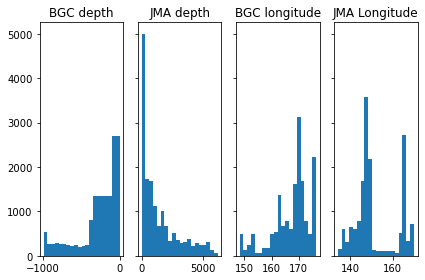

In [10]:
n_bins = 20
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, sharey=True, tight_layout=True)

ax1.hist(bgcdata['DEPTH[M]'], bins=n_bins)
ax2.hist(jmadata['depth'], bins=n_bins)
ax3.hist(bgcdata['LON'], bins=n_bins)
ax4.hist(jmadata['lon'], bins=n_bins)

ax1.set_title("BGC depth")
ax2.set_title("JMA depth")
ax3.set_title("BGC longitude")
ax4.set_title("JMA Longitude")

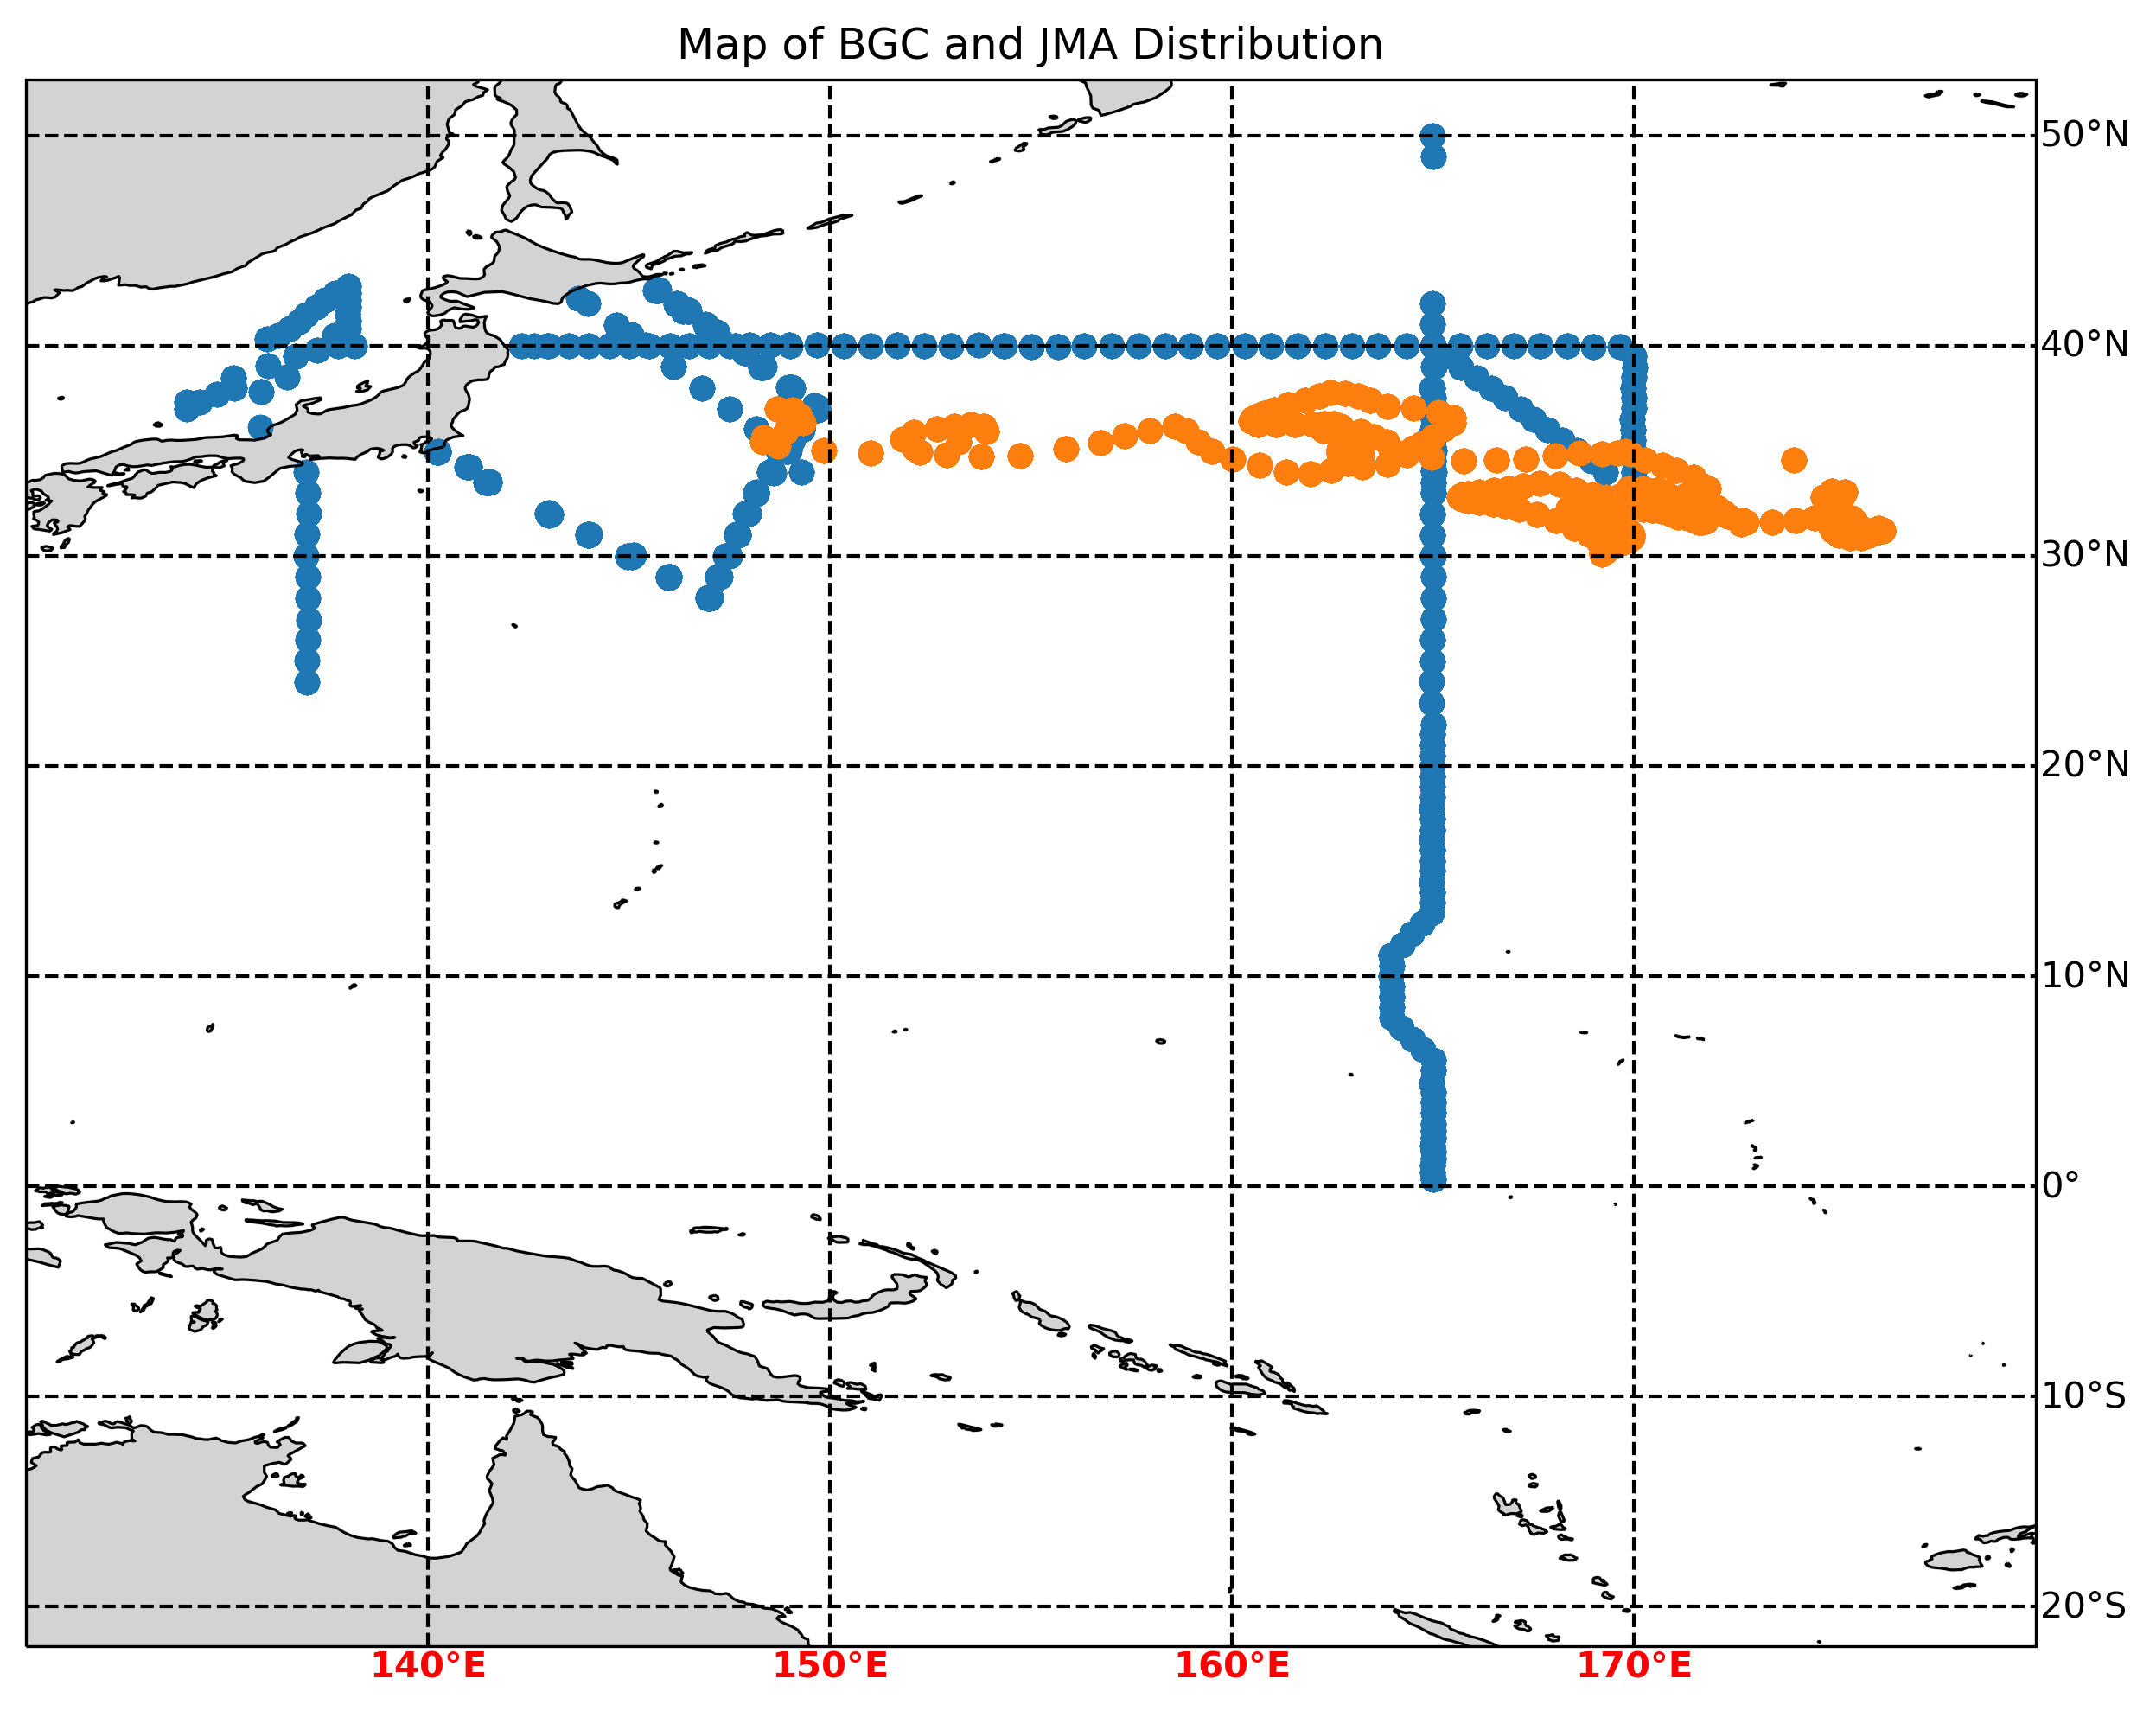

In [55]:
# Create a regional map with parallels and meridians

fig = plt.figure(figsize = (10,8), dpi = 300)
ax = fig.add_subplot(1,1,1, projection = ccrs.PlateCarree(), aspect = "auto", adjustable = "box")

# ax.set_extent(east, west, south, north)
ax.set_extent([130.0, 180.0, -20.0, 50.0])

# Being picky with our coastlines
ax.coastlines(linewidth=0.75, color='black')

# Map title
ax.set_title('Map of BGC and JMA Distribution')#, color = 'red', weight = 'bold')
# how to add lines of latitude and longitude
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

ax.scatter(jmadata['lon'],jmadata['lat'], c= '#1f77b4')
ax.scatter(bgcdata['LON'],bgcdata['LAT'], c= '#ff7f0e')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k',linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

ax.add_feature(cp.feature.LAND, facecolor = 'lightgrey')




In [47]:
jmadata['l']

0        140.242833
3        140.242833
4        140.242833
5        140.242833
6        140.242833
            ...    
16216    145.709167
16217    145.709167
16218    145.709167
16219    145.709167
16220    145.709167
Name: lon, Length: 15574, dtype: float64

In [ ]:
fig = plt.figure(figsize = (8,6), dpi = 300)
pt = plt.get_cmap('jet', 12)

# gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.6]) 

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree(), aspect="auto", adjustable='box')
ax.set_extent([130.0, 180.0, 0, 50.0], ccrs.PlateCarree())

ax.add_feature(cfeature.GSHHSFeature(scale='full'), facecolor = 'lightgrey')

wod = ax.scatter(jmadata['lon'],jmadata['lat'],100, c = wod_m, cmap = pt, vmin = 0.5, vmax = 12.5)


I dont even want to know why that longitude problem, is occurring. its likely due to the unit (referenced to prime merdian or not... something like that).... we can doll it up later.. i am just gunna try to build machinary to dial in from there. 

(array([   0., 1083.,  960., 1440., 1379., 1440., 1440., 1434., 1440.,
        1260., 1440., 1380., 1440.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <BarContainer object of 13 artists>)

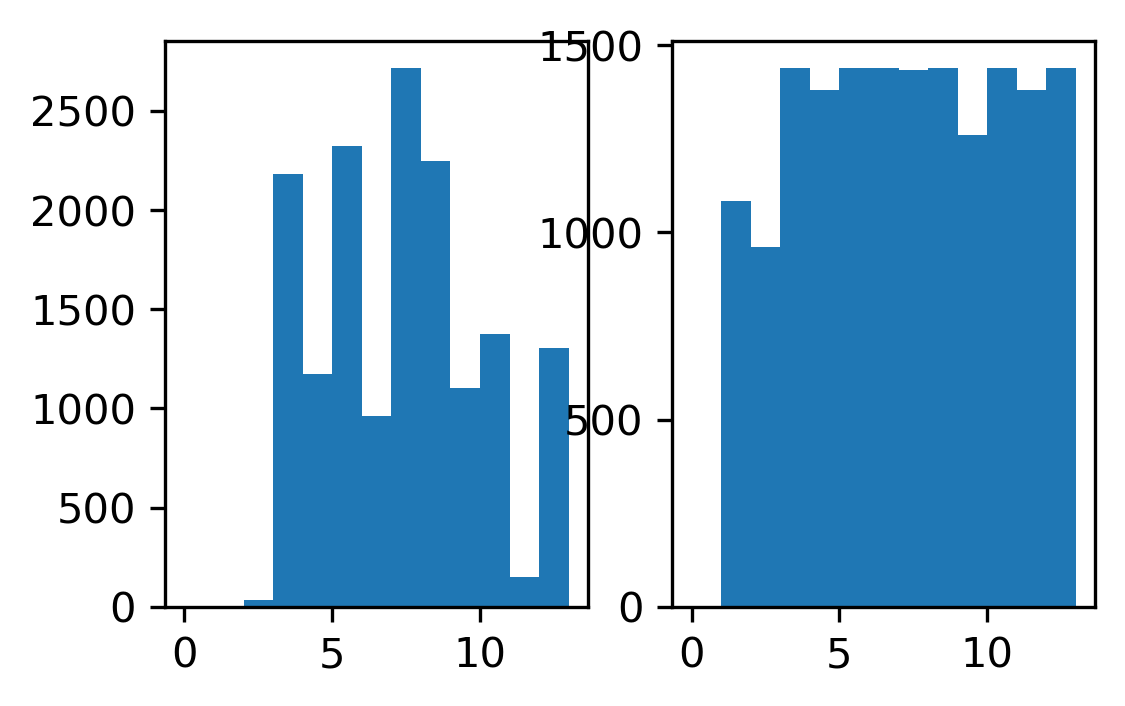

In [11]:
fig,[ax1,ax2] = plt.subplots(1,2, figsize = (4,2.5), dpi = 300)

ax1.hist(jmadata['month'], bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13])
ax2.hist(bgcdata['month'], bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13])


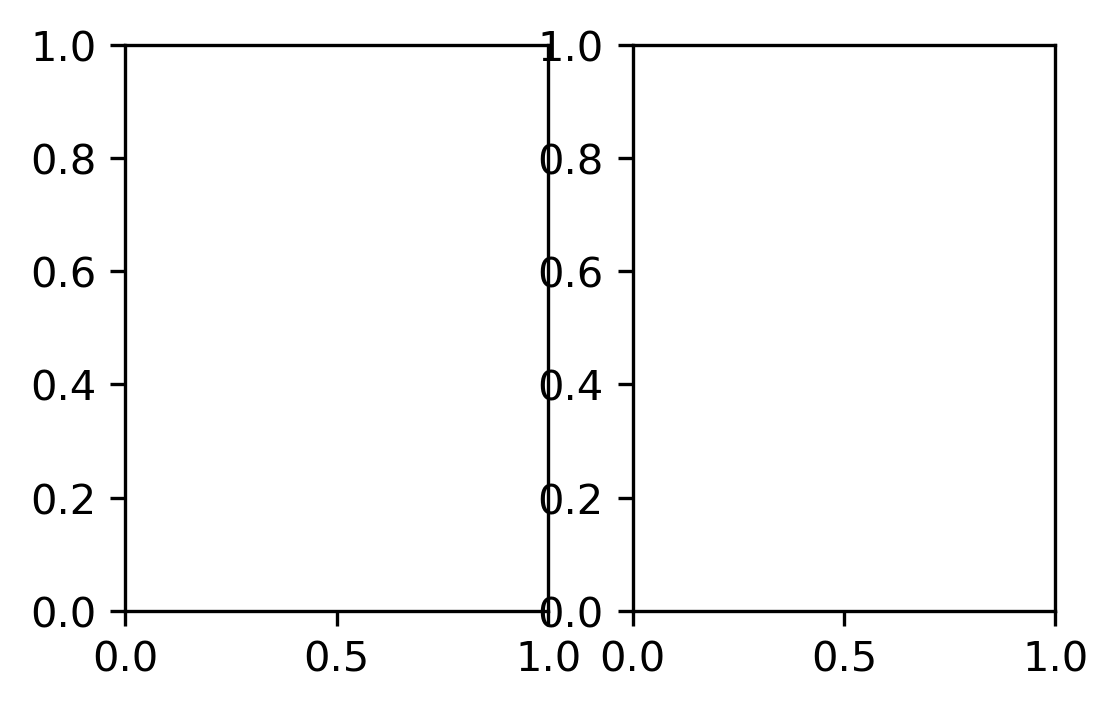

In [13]:
fig,[ax1,ax2] = plt.subplots(1,2, figsize = (4,2.5), dpi = 300)
# year_bins = range()
#ax1.hist(jmadata['year'], bins = [2000:2020])
# ax2.hist(bgcdata['year'], bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13])

## Part 2 (40 points): Model application and evaluation

Apply your nitrate model trained on the JMA dataset to the BGC Argo data to estimate nitrate concentrations based on your input variables (e.g. temperature, salinity, etc…).

Compare the observed BGC Argo nitrate to the values predicted by your model.

Report the r2 score and RMSE (root mean squared error).
Does your model perform consistently well, or are there any noticeable outliers? If there are, identify those data points and suggest reasons why you think that your model performs less well for those points.

In [14]:
# Make the data split
y = jmadata.nitrate
X = jmadata[['density','depth','sal']]

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4)
# test size is the percentage of test points you want, random state is the "seed" number so people can reproduce what you have done

In [15]:
# just to look and check them
len(X_test)

3115

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
standardized_X = scaler.transform(X_train)
standardized_X_test = scaler.transform(X_test)

In [17]:

# pick model
n  = int(input('Choose a number for k: '))

from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=n)
model.fit(standardized_X, y_train)

# compute the R^2 score
print("R^2 score: {0:.2f}".format(model.score(standardized_X, y_train)))

# plot the model together with the data
y_pred = model.predict(standardized_X_test)

#plt.scatter(standardized_X, y_train)
#plt.plot(standardized_X_test,y_pred)
#plt.show()

from sklearn.metrics import mean_squared_error, r2_score


print('r2 =', r2_score(y_train, model.predict(standardized_X)))
print('r2 =', r2_score(y_test, y_pred))
print('RMSE =',np.sqrt(mean_squared_error(y_test, y_pred)))
# we want to minimize RMSE with our model (its how good our model is)

Choose a number for k: 20
R^2 score: 0.99
r2 = 0.9913753618285206
r2 = 0.9903193065354323
RMSE = 1.5181197433194062


In [18]:
# For loop to find the best model k
k = []
r2_train = []
r2_test = []
RMSE = []

loops = range(1,31)

for n in loops:
    model = KNeighborsRegressor(n_neighbors=n)
    model.fit(standardized_X, y_train)

    # Use the model to predict y (nitrate values)
    y_pred = model.predict(standardized_X_test)
    
    # Form our lists to plot
    k.append(n)
    r2_train.append(r2_score(y_train, model.predict(standardized_X)))
    r2_test.append(r2_score(y_test, y_pred))
    RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))

Text(0, 0.5, 'r2 for test')

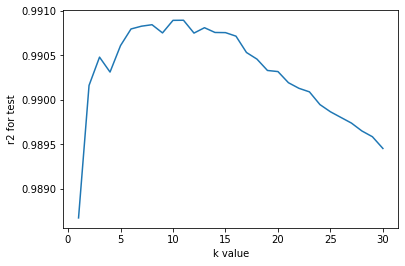

In [19]:
plt.plot(k,r2_test)
plt.xlabel('k value')
plt.ylabel('r2 for test')

Text(0, 0.5, 'RMSE')

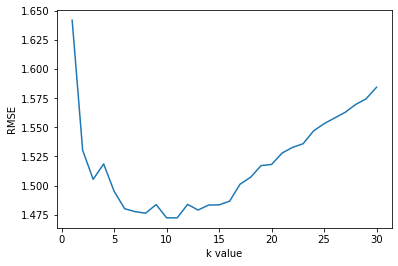

In [20]:
plt.plot(k,RMSE)
plt.xlabel('k value')
plt.ylabel('RMSE')

When running with 100 versions of k (1-100) shows that RMSE increases and r^2 decreases after around 30. Thus, we ran the loop again with only 1-30 for k. We chose k = 5, since it has the lowest RMSE and highest r^2. We will plot to determine if there is overfitting, and then reevaluate. 

In [21]:
# Run the model at k = 5
model10 = KNeighborsRegressor(n_neighbors= 5)
model10.fit(standardized_X, y_train)

# compute the R^2 score
print("R^2 score: {0:.2f}".format(model.score(standardized_X, y_train)))

# plot the model together with the data
y_pred_10 = model.predict(standardized_X_test)

#plt.scatter(standardized_X, y_train)
#plt.plot(standardized_X_test,y_pred)
#plt.show()

from sklearn.metrics import mean_squared_error, r2_score


print('r2 =', r2_score(y_train, model10.predict(standardized_X)))
print('r2 =', r2_score(y_test, y_pred_10))
print('RMSE =',np.sqrt(mean_squared_error(y_test, y_pred_10)))
# we want to minimize RMSE with our model (its how good our model is)

R^2 score: 0.99
r2 = 0.9943386077569599
r2 = 0.9894552476867665
RMSE = 1.5844224433891965


In [22]:
# Need to pull out each X variable for plotting
density_test = X_test[['density']]
depth_test = X_test[['depth']]
sal_test = X_test[['sal']]

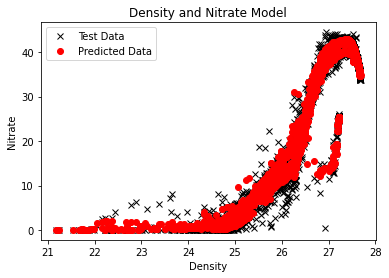

In [23]:
# Plot to check for overfitting (will follow the outliers exactly)
plt.plot(density_test, y_test, 'xk', label = "Test Data")
plt.plot(density_test, y_pred_10, 'ro', label = "Predicted Data")
plt.xlabel('Density')
plt.ylabel('Nitrate')
plt.title('Density and Nitrate Model')
plt.legend()

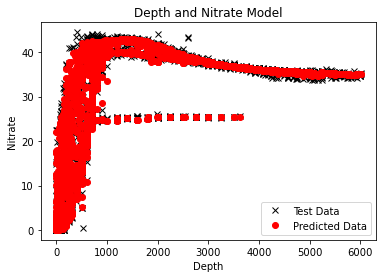

In [24]:
plt.plot(depth_test, y_test, 'xk', label = "Test Data")
plt.plot(depth_test, y_pred_10, 'ro', label = "Predicted Data")
plt.xlabel('Depth')
plt.ylabel('Nitrate')
plt.title('Depth and Nitrate Model')
plt.legend()

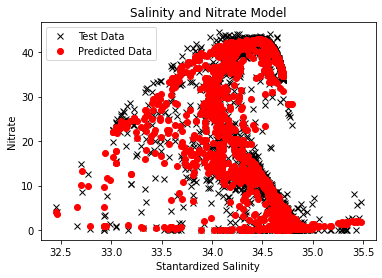

In [26]:
plt.plot(sal_test, y_test, 'xk', label = "Test Data")
plt.plot(sal_test, y_pred_10, 'ro', label = "Predicted Data")
plt.xlabel('Stantardized Salinity')
plt.ylabel('Nitrate')
plt.title('Salinity and Nitrate Model')
plt.legend()

In [27]:
# Test the model with the BGC Argo data
# bgcdata and bgcno3data
X_bgc = bgcdata[['SIGMATHETA[KG/M3]','DEPTH[M]','SALINITY[PSS]']]

# scaler = StandardScaler().fit(X_train)
stand_X_bgc = scaler.transform(X_bgc)

# plot the model together with the data
bgc_y_pred = model.predict(stand_X_bgc)

#plt.scatter(standardized_X, y_train)
#plt.plot(standardized_X_test,y_pred)
#plt.show()

y_bgc = bgcno3data[['NITRATE[uMOL/KG]']]


print('r2 =', r2_score(y_bgc, bgc_y_pred))
print('RMSE =',np.sqrt(mean_squared_error(y_bgc, bgc_y_pred)))
# we want to minimize RMSE with our model (its how good our model is)

r2 = 0.3655051168496878
RMSE = 10.519519823668103


In [28]:
# Need to pull out each standardized X variable for plotting
bgc_stand_density = stand_X_bgc[:,0]
bgc_stand_depth = stand_X_bgc[:,1]
bgc_stand_sal = stand_X_bgc[:,2]

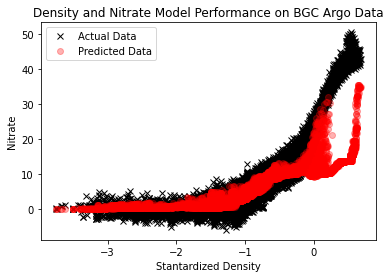

In [33]:
# Plot to check for overfitting (will follow the outliers exactly)
plt.plot(bgc_stand_density, y_bgc, 'xk', label = "Actual Data")
plt.plot(bgc_stand_density, bgc_y_pred, 'ro', alpha = 0.3, label = "Predicted Data")
plt.xlabel('Stantardized Density')
plt.ylabel('Nitrate')
plt.title('Density and Nitrate Model Performance on BGC Argo Data')
plt.legend()

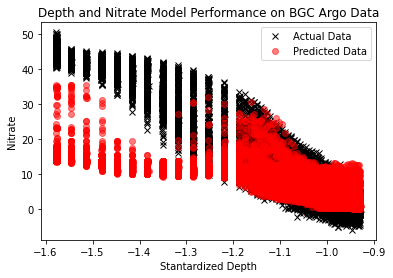

In [32]:
plt.plot(bgc_stand_depth, y_bgc, 'xk', label = "Actual Data")
plt.plot(bgc_stand_depth, bgc_y_pred, 'ro', alpha = 0.3, label = "Predicted Data")
plt.xlabel('Stantardized Depth')
plt.ylabel('Nitrate')
plt.title('Depth and Nitrate Model Performance on BGC Argo Data')
plt.legend()

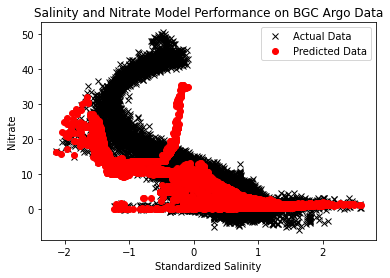

In [31]:
plt.plot(bgc_stand_sal, y_bgc, 'xk', label = "Actual Data")
plt.plot(bgc_stand_sal, bgc_y_pred, 'ro', alpha = 0.3, label = "Predicted Data")
plt.xlabel('Standardized Salinity')
plt.ylabel('Nitrate')
plt.title('Salinity and Nitrate Model Performance on BGC Argo Data')
plt.legend()